# QUA 2.0 examples

here we show 3 examples for QUA2.0 use:

1. 2 qubit randomized benchmarking
2. 3 qubit repetition code
3. a (pathological) example with conditional operations

I think the main issues with this language are:

1. The interaction of `no_gaps` with `parallel` is complicated. The main problem is that if I want to move a pulse in time I have to think about how I structure the overall flow and it's far from trivial.

2. It is easy to use this language as a target language from qiskit, when feedback is not involved. However the problems are that a. there is no way of understanding the logical meaning of the pulses for complex pulses, and b. once you introduce feedback it becomes hard. You have to do heuristics about what to put in a parallel block, how many parallel block to use and so on.

2. Writing things explicitly is hard, but this is OK because it's a target language. 

In [2]:
%cd ../..
%load_ext autoreload
%autoreload 2

/home/lior/git/research/gatelevel


In [98]:
#Import general libraries (needed for functions)`
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
from gatelevel_qiskit.waveform_comparator import WaveformComparator

#Import the RB Functions
import qiskit.ignis.verification.randomized_benchmarking as rb
from qiskit.pulse import Schedule, Play, Gaussian, DriveChannel, ShiftPhase, Waveform, ControlChannel, MeasureChannel, AcquireChannel
from qiskit.circuit import Gate
#Import Qiskit classes 
import qiskit
from pprint import pprint
from deepdiff import DeepDiff
from qiskit import ClassicalRegister, QuantumRegister

from gatelevel_qiskit.circuit_to_qua2 import CircuitQua2Transformer
from gatelevel_qiskit.lib import wfs_no_samples, summary_of_inst, get_min_time
from gatelevel_qiskit.simple_backend import simple_backend
from rb_config2 import config_base


## Open questions

1. can we update frequency inside no_gaps?
2. where to put frame?

## Randomized Benchmarking - 2 Qubit example


### Setting up

here we show a simple example of an RB circuit with 2 qubits.

The translation from a pulse schedule to QUA 2.0 is simple here. However it suffers from 2 problems:

1. **it is wasteful, because we add instructions blindly and repeat ourselves many times **
2. it is difficult to see from the code what is going on because we sliced the pulses per thread and so there is no logical grouping of pulses - this is related to the previous problem but might be OK, it's more of a readability issue.

In [104]:
# generate RB 2QB
c1 = qiskit.circuit.quantumcircuit.QuantumCircuit(2)
c1.x(0)
rb_circs1, xdata = rb.randomized_benchmarking_seq(length_vector=[1,2,3,4,5], nseeds=3, rb_pattern=[[0, 1]])
circ = rb_circs1[0][0]

In [100]:
circ.draw()

┌───┐┌─────┐┌───┐     ┌─────┐┌───┐     ┌───┐┌───┐ ░ ┌─────┐┌───┐     »
qr_0: ┤ Z ├┤ SDG ├┤ H ├──■──┤ SDG ├┤ H ├──■──┤ H ├┤ S ├─░─┤ SDG ├┤ H ├──■──»
      ├───┤└┬───┬┘├───┤┌─┴─┐└┬───┬┘├───┤┌─┴─┐└───┘└───┘ ░ └─────┘└───┘┌─┴─┐»
qr_1: ┤ Y ├─┤ H ├─┤ S ├┤ X ├─┤ H ├─┤ S ├┤ X ├───────────░─────────────┤ X ├»
      └───┘ └───┘ └───┘└───┘ └───┘ └───┘└───┘           ░             └───┘»
cr: 2/═════════════════════════════════════════════════════════════════════»
                                                                           »
«       ┌───┐ ┌───┐      ┌───┐ ┌───┐┌───┐┌─┐   
«qr_0: ─┤ H ├─┤ S ├──■───┤ H ├─┤ S ├┤ Z ├┤M├───
«      ┌┴───┴┐├───┤┌─┴─┐┌┴───┴┐├───┤├───┤└╥┘┌─┐
«qr_1: ┤ SDG ├┤ H ├┤ X ├┤ SDG ├┤ H ├┤ Y ├─╫─┤M├
«      └─────┘└───┘└───┘└─────┘└───┘└───┘ ║ └╥┘
«cr: 2/═══════════════════════════════════╩══╩═
«                                         0  1

In [105]:
circ_qua = CircuitQua2Transformer(pulse_backend=simple_backend,
                                config_base=config_base,
                                circuit=circ)

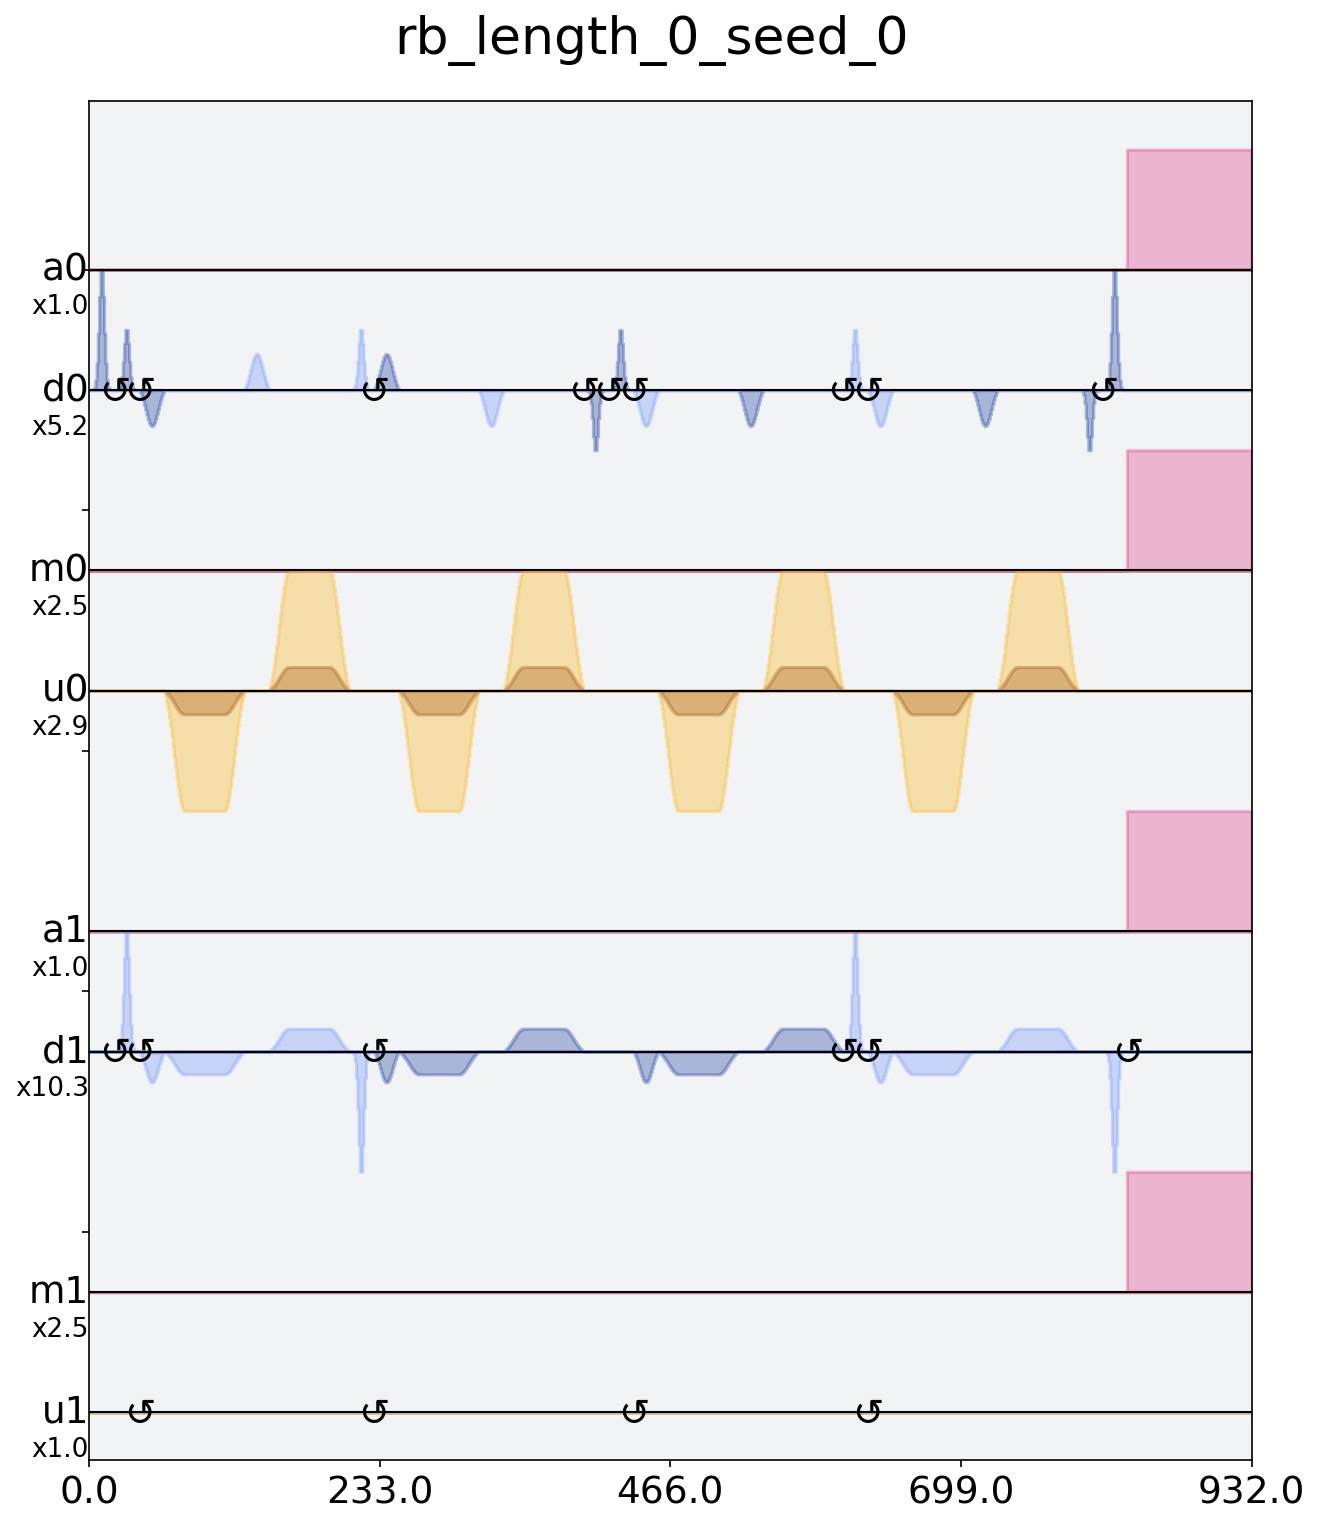

In [106]:
circ_qua._schedule.draw()

### QUA2.0 pseudocode

In [107]:
print(circ_qua.to_qua())

    no_gaps:
        parallel:
            do('d0'):
                play('wf_Y', oscillator=0, frame=0, port=['(con1, 1)', '(con1, 2)'])
                frame_rotation_2pi(phase=0.25,frame=0)
                play('wf_X90', oscillator=0, frame=0, port=['(con1, 1)', '(con1, 2)'])
                frame_rotation_2pi(phase=0.25,frame=0)
                frame_rotation_2pi(phase=0.25,frame=0)
                frame_rotation_2pi(phase=0.25,frame=0)
                play('Ym_d0', oscillator=0, frame=0, port=['(con1, 1)', '(con1, 2)'])
                wait(16)
                play('Xp_d0', oscillator=0, frame=0, port=['(con1, 1)', '(con1, 2)'])
                frame_rotation_2pi(phase=-0.25,frame=0)
                frame_rotation_2pi(phase=0.25,frame=0)
                wait(16)
                play('wf_X90', oscillator=0, frame=0, port=['(con1, 1)', '(con1, 2)'])
                frame_rotation_2pi(phase=0.25,frame=0)
                frame_rotation_2pi(phase=0.25,frame=0)
                play('Ym_

## 3 Qubit repetition code

### the circuit

Points to note:

1. placement of "movable" gates such as the Hadamards in the beginning
2. placement of measurements
3. decoding must be done with minimal latency

the examples requires 5 qubits, connectivity can be planar (<4 NN couplings per qubit)

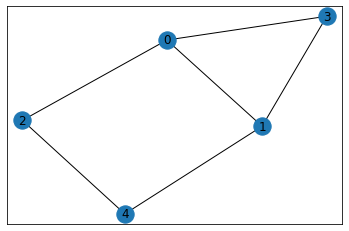

In [113]:
import networkx as nx
g = nx.Graph()
g.add_edges_from([(0,1), (0,2), (0,3), (1,3), (1,4), (2,4)])
nx.draw_networkx(g)

In [115]:

q = QuantumRegister(5, name="qce")
c = ClassicalRegister(2, name="cce")
ce = qiskit.QuantumCircuit(q, c)
ce.reset(q[1:])
ce.h(q[1:])
ce.cz(0,1)
ce.cz(0,2)
ce.h([1,2])
ce.barrier()
ce.cz(0,3)
ce.cz(1,3)
ce.h(3)
ce.cz(1,4)
ce.cz(2,4)
ce.h(4)
ce.measure([3,4],[0,1])
ce.barrier()
ce.x(0).c_if(c, 1)
ce.x(2).c_if(c, 3)
ce.x(1).c_if(c, 2)

ce.draw()

░                              ░  ┌───┐        »
qce_0: ───────────■──■───────░──■───────────────────────────░──┤ X ├────────»
            ┌───┐ │  │ ┌───┐ ░  │                           ░  └─┬─┘        »
qce_1: ─|0>─┤ H ├─■──┼─┤ H ├─░──┼──■───────■────────────────░────┼──────────»
            ├───┤    │ ├───┤ ░  │  │       │                ░    │    ┌───┐ »
qce_2: ─|0>─┤ H ├────■─┤ H ├─░──┼──┼───────┼──■─────────────░────┼────┤ X ├─»
            ├───┤      └───┘ ░  │  │ ┌───┐ │  │ ┌─┐         ░    │    └─┬─┘ »
qce_3: ─|0>─┤ H ├────────────░──■──■─┤ H ├─┼──┼─┤M├─────────░────┼──────┼───»
            ├───┤            ░       └───┘ │  │ └╥┘┌───┐┌─┐ ░    │      │   »
qce_4: ─|0>─┤ H ├────────────░─────────────■──■──╫─┤ H ├┤M├─░────┼──────┼───»
            └───┘            ░                   ║ └───┘└╥┘ ░ ┌──┴──┐┌──┴──┐»
cce: 2/══════════════════════════════════════════╩═══════╩════╡ = 1 ╞╡ = 3 ╞»
                                                 0       1    └─────┘└─────┘»
«              
«qce_0: ───────
«        ┌───┐ 
«qce_1: ─┤ X ├─
«        └─┬─┘ 
«qce_2: ───┼───
«          │   
«qce_3: ───┼───
«          │   
«qce_4: ───┼───
«       ┌──┴──┐
«cce: 2/╡ = 2 ╞
«       └─────┘

### QUA2.0 pseudocode

**timing here is meaningless - the actual timing must be set by the translator from transpiled gatelevel to pulse schedule**

In [ ]:
deterministic:
    no_gaps:
        
        # active reset
        parallel:
            do('d1'):
                measure('pulse_to_1', oscillator=4,frame=10, port=[(con1, 9), (con1, 10)], ('integw', I[1]))
                with while_(I[1] > 0):
                    measure('pulse_to_1', oscillator=4,frame=10, port=[(con1, 9), (con1, 10)], ('integw', I[1]))
                    play('wf_X', oscillator=1, frame=1, port=[(con1, 3), (con1, 4)])
            do('d2'):
                measure('pulse_to_2', oscillator=4,frame=10, port=[(con1, 9), (con1, 10)], ('integw', I[2]))
                with while_(I[2] > 0):
                    measure('pulse_to_2', oscillator=4,frame=10, port=[(con1, 9), (con1, 10)], ('integw', I[2]))
                    play('wf_X', oscillator=2, frame=2, port=[(con1, 5), (con1, 6)])
            do('d3'):
                measure('pulse_to_3', oscillator=4,frame=10, port=[(con1, 9), (con1, 10)], ('integw', I[3]))
                with while_(I[3] > 0):
                    measure('pulse_to_3', oscillator=4,frame=10, port=[(con1, 9), (con1, 10)], ('integw', I[3]))
                    play('wf_X', oscillator=3, frame=3, port=[(con1, 7), (con1, 8)])
            do('d4'):
                measure('pulse_to_4', oscillator=4,frame=10, port=[(con1, 9), (con1, 10)], ('integw', I[4]))
                with while_(I[4] > 0):
                    measure('pulse_to_4', oscillator=4,frame=10, port=[(con1, 9), (con1, 10)], ('integw', I[4]))
                    play('wf_X', oscillator=4, frame=4, port=[(con1, 9), (con1, 10)])

        
        parallel:  # note that if I decide to move the Hadamards in time, all of this code structure will have to break
            do('d1'):
                frame_rotation_2pi(phase=0.5,frame=0)
                play('wf_X90', oscillator=1, frame=1, port=[(con1, 3), (con1, 4)])
                frame_rotation_2pi(phase=0.5,frame=0)
            do('d2'):
                frame_rotation_2pi(phase=0.5,frame=0)
                play('wf_X90', oscillator=2, frame=2, port=[(con1, 5), (con1, 6)])
                frame_rotation_2pi(phase=0.5,frame=0)
            do('d3'):
                frame_rotation_2pi(phase=0.5,frame=0)
                play('wf_X90', oscillator=3, frame=3, port=[(con1, 7), (con1, 8)])
                frame_rotation_2pi(phase=0.5,frame=0)
            do('d4'):
                frame_rotation_2pi(phase=0.5,frame=0)
                play('wf_X90', oscillator=4, frame=4, port=[(con1, 9), (con1, 10)])
                frame_rotation_2pi(phase=0.5,frame=0)

        # for cz(0,1), now maybe something like this?
        parallel:
            do('u01'):
                play('CRecho0', oscillator=1, frame=6, port=[(con1, 1), (con1, 2)])
                # wait
                play('CRecho0m', oscillator=1, frame=6, port=[(con1, 1), (con1, 2)])
            do('d1'):
                # compensation 0
                # wait
                # -compensation 0
            do('d0'):
                # wait
                # echo
                # wait
        # for cz(0,2)
        parallel:
            do('u02'):
                play('CRecho0', oscillator=2, frame=7, port=[(con1, 1), (con1, 2)])
                # wait
                play('CRecho0m', oscillator=2, frame=7, port=[(con1, 1), (con1, 2)])
            do('d2'):
                # compensation 0
                # wait
                # -compensation 0
            do('d0'):
                # wait
                # echo
                # wait
        parallel:
            do('d1'):
                frame_rotation_2pi(phase=0.5,frame=0)
                play('wf_X90', oscillator=1, frame=1, port=[(con1, 3), (con1, 4)])
                frame_rotation_2pi(phase=0.5,frame=0)
            do('d2'):
                frame_rotation_2pi(phase=0.5,frame=0)
                play('wf_X90', oscillator=2, frame=2, port=[(con1, 5), (con1, 6)])
                frame_rotation_2pi(phase=0.5,frame=0)
        # for cz(0,3)
        parallel:
            do('u03'):
                # cphase 0
                # wait
                # -cphase 0
            do('d3'):
                # compensation 0
                # wait
                # -compensation 0
            do('d0'):
                # wait
                # echo
                # wait
            # for cz(1,3)
        parallel:
            do('u13'):
                play('CRecho0', oscillator=3, frame=8, port=[(con1, 3), (con1, 4)])
                # wait
                play('CRecho0m', oscillator=3, frame=8, port=[(con1, 3), (con1, 4)])
            do('d3'):
                # compensation 0
                # wait
                # -compensation 0
            do('d1'):
                # wait
                # echo
                # wait
        parallel:
            do('d1'):
                frame_rotation_2pi(phase=0.5,frame=0)
                play('wf_X90', oscillator=0, frame=0, port=[(con1, 3), (con1, 4)])
                frame_rotation_2pi(phase=0.5,frame=0)
        # for cz(1,4)
        parallel:
            do('u03'):
                # cphase 0
                # wait
                # -cphase 0
            do('d3'):
                # compensation 0
                # wait
                # -compensation 0
            do('d0'):
                # wait
                # echo
                # wait
            # for cz(2,4)
        parallel:
            do('u13'):
                # cphase 0
                # wait
                # -cphase 0
            do('d3'):
                # compensation 0
                # wait
                # -compensation 0
            do('d1'):
                # wait
                # echo
                # wait

        do('d4'):
            frame_rotation_2pi(phase=0.5,frame=0)
            play('wf_X90', oscillator=0, frame=0, port=[(con1, 9), (con1, 10)])
            frame_rotation_2pi(phase=0.5,frame=0)

        parallel:
            do('m0'):
                measure('pulse_to_3', oscillator=4,frame=5, port=[(con1, 9), (con1, 10)], ('integw', I[3]))
            do('m1'):
                measure('pulse_to_4', oscillator=4,frame=5, port=[(con1, 9), (con1, 10)], ('integw', I[4]))

    c[0] = I[0] > 0
    c[1] = I[1] > 0

    no_gaps:
        switch(int(c)):
            case(1):
                play('wf_X', oscillator=0, frame=0, port=[(con1, 1), (con1, 2)])
            case(2):
                play('wf_X', oscillator=0, frame=0, port=[(con1, 5), (con1, 6)])
            case(3):
                play('wf_X', oscillator=0, frame=0, port=[(con1, 3), (con1, 4)])



## Conditional operations

this example seems to me to be pathological. Because we need to get out of the no_gaps block while staying in the parallel block.

In [45]:
from qiskit.circuit.library import XGate, YGate, SdgGate, SGate, CXGate

gateset = [XGate(), YGate(), SdgGate(), SGate()]
# generate conditional circuit
q = QuantumRegister(2)
c = ClassicalRegister(2)
c1 = qiskit.QuantumCircuit(q, c)
c1.reset(q[0])
c1.reset(q[1])
c1.h(q[0])
c1.h(q[0])
c1.cnot(q[0], q[1])
c1.s(q[1])
for _ in range(10):
    c1.append(np.random.choice(gateset), [q[1]])
c1.sdg(q[0])
c1.measure(q[0], c[0])
c1.x(q[0]).c_if(c, 0)
c1.measure(q[0], c[0])
for _ in range(4):
    c1.append(np.random.choice(gateset), [q[0]])
c1.cnot(q[0], q[1])
c1.measure(q, c)
c1.draw()



┌───┐┌───┐     ┌─────┐     ┌─┐        ┌───┐      ┌─┐┌─────┐┌───┐»
q21_0: ─|0>─┤ H ├┤ H ├──■──┤ SDG ├─────┤M├────────┤ X ├──────┤M├┤ SDG ├┤ X ├»
            └───┘└───┘┌─┴─┐└┬───┬┘┌───┐└╥┘┌─────┐ └─┬─┘ ┌───┐└╥┘└┬───┬┘├───┤»
q21_1: ─|0>───────────┤ X ├─┤ S ├─┤ S ├─╫─┤ SDG ├───┼───┤ X ├─╫──┤ S ├─┤ X ├»
                      └───┘ └───┘ └───┘ ║ └─────┘┌──┴──┐└───┘ ║  └───┘ └───┘»
c21: 2/═════════════════════════════════╩════════╡ = 0 ╞══════╩═════════════»
                                        0        └─────┘      0             »
«       ┌───┐┌───┐                      ┌─┐   
«q21_0: ┤ S ├┤ X ├───────────────────■──┤M├───
«       ├───┤├───┤┌───┐┌───┐┌─────┐┌─┴─┐└╥┘┌─┐
«q21_1: ┤ Y ├┤ S ├┤ S ├┤ X ├┤ SDG ├┤ X ├─╫─┤M├
«       └───┘└───┘└───┘└───┘└─────┘└───┘ ║ └╥┘
«c21: 2/═════════════════════════════════╩══╩═
«                                        0  1